# 混合模型训练 - Google Colab版本

这个notebook实现了Nested Logit（任务分配）+ RL（执行）的混合仓库模型，并利用GPU加速训练。

## 1. 环境设置

In [ ]:
# 检查GPU
import torch
if torch.cuda.is_available():
    print(f"✅ GPU可用: {torch.cuda.get_device_name(0)}")
    print(f"   GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("❌ GPU不可用，使用CPU训练")
    print("   请在菜单栏选择: Runtime -> Change runtime type -> GPU")

✅ GPU可用: Tesla T4
   GPU内存: 14.7 GB


In [ ]:
# 安装必要的包
!pip install -q numpy pandas matplotlib tqdm

In [ ]:
# 挂载Google Drive（用于保存模型）
from google.colab import drive
drive.mount('/content/drive')

# 创建保存目录
import os
save_dir = '/content/drive/MyDrive/HybridModel/'
os.makedirs(save_dir, exist_ok=True)
print(f"模型将保存到: {save_dir}")

Mounted at /content/drive
模型将保存到: /content/drive/MyDrive/HybridModel/


## 2. 导入库和设置

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
from typing import Dict, List, Tuple, Optional
import logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime
import time

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


## 3. 模型定义

In [ ]:
class NestedLogitManager:
    """第一层：Nested Logit任务分配"""

    def __init__(self, num_pickers: int = 6):
        self.num_pickers = num_pickers
        self.picker_ids = [f"P{i}" for i in range(num_pickers)]

        self.params = {
            'w_distance': -0.5,
            'w_workload': -0.3,
            'w_priority': 1.0,
            'w_equipment': 2.0,
            'w_idle_time': 0.5,
            'lambda': 0.7
        }

    def compute_utility(self, order_features: Dict, picker_features: Dict[str, Dict]) -> Dict[str, float]:
        utilities = {}

        for picker_id, features in picker_features.items():
            utility = (
                self.params['w_distance'] * (features['distance'] / 50.0) +
                self.params['w_workload'] * (features['workload'] / 20.0) +
                self.params['w_priority'] * (order_features['priority_score'] / 3.0) +
                self.params['w_equipment'] * features['equipment_match'] +
                self.params['w_idle_time'] * (features['idle_time'] / 3600.0)
            )
            utilities[picker_id] = utility

        return utilities

    def assign_task(self, order_features: Dict, picker_features: Dict[str, Dict]) -> Tuple[str, Dict]:
        utilities = self.compute_utility(order_features, picker_features)

        # 转换为概率
        max_util = max(utilities.values())
        exp_utilities = {pid: np.exp((u - max_util) / self.params['lambda'])
                        for pid, u in utilities.items()}
        total = sum(exp_utilities.values())
        probs = {pid: exp_u / total for pid, exp_u in exp_utilities.items()}

        # 选择拣货员
        chosen_picker = np.random.choice(list(probs.keys()), p=list(probs.values()))

        return chosen_picker, {'probs': probs, 'utilities': utilities}

In [ ]:
class PolicyNetwork(nn.Module):
    """策略网络（GPU优化）"""

    def __init__(self, state_dim: int, hidden_dim: int, action_dim: int):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)
        return F.softmax(logits, dim=-1)


class RLPicker:
    """第二层：强化学习拣货员"""

    def __init__(self, picker_id: str, state_dim: int = 10,
                 action_dim: int = 5, hidden_dim: int = 64):
        self.picker_id = picker_id
        self.policy = PolicyNetwork(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.memory = deque(maxlen=2000)
        self.position = (1, 0)
        self.workload = 0

    def get_state(self, order_location: Tuple[int, int],
                  warehouse_state: Dict) -> torch.Tensor:
        """构建状态向量"""
        state = [
            self.position[0] / 32.0,
            self.position[1] / 20.0,
            order_location[0] / 32.0,
            order_location[1] / 20.0,
            (order_location[0] - self.position[0]) / 32.0,
            (order_location[1] - self.position[1]) / 20.0,
            self.workload / 20.0,
            warehouse_state.get('congestion', 0),
            warehouse_state.get('time_pressure', 0),
            0  # padding
        ]
        return torch.FloatTensor(state).to(device)

    def select_action(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """选择动作"""
        with torch.no_grad():
            action_probs = self.policy(state.unsqueeze(0))
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update_position(self, action: int, target: Tuple[int, int]) -> Tuple[int, int]:
        """更新位置"""
        x, y = self.position

        if action == 0:  # 停留
            return self.position
        elif action == 1 and x < 31:  # 右
            new_pos = (x + 1, y)
        elif action == 2 and x > 0:  # 左
            new_pos = (x - 1, y)
        elif action == 3 and y < 19:  # 下
            new_pos = (x, y + 1)
        elif action == 4 and y > 0:  # 上
            new_pos = (x, y - 1)
        else:
            # 贪心移动
            if abs(target[0] - x) > abs(target[1] - y):
                new_pos = (x + np.sign(target[0] - x), y)
            else:
                new_pos = (x, y + np.sign(target[1] - y))

        self.position = new_pos
        return new_pos

## 4. 混合系统实现

In [ ]:
class HybridWarehouseSystem:
    """GPU优化的混合仓库系统"""

    def __init__(self, num_pickers: int = 6):
        self.num_pickers = num_pickers
        self.manager = NestedLogitManager(num_pickers)
        self.pickers = {f"P{i}": RLPicker(f"P{i}") for i in range(num_pickers)}

    def process_order(self, order_features: Dict, picker_features: Dict[str, Dict],
                     warehouse_state: Dict) -> Dict:
        """处理订单"""
        # 任务分配
        chosen_picker, assignment_info = self.manager.assign_task(order_features, picker_features)

        # 执行任务
        picker = self.pickers[chosen_picker]
        target_location = order_features['pickup_location']

        trajectory = []
        total_reward = 0
        steps = 0
        max_steps = 100

        while picker.position != target_location and steps < max_steps:
            # 获取状态
            state = picker.get_state(target_location, warehouse_state)

            # 选择动作
            action, log_prob = picker.select_action(state)

            # 执行动作
            old_pos = picker.position
            new_pos = picker.update_position(action, target_location)

            # 计算奖励
            old_dist = abs(old_pos[0] - target_location[0]) + abs(old_pos[1] - target_location[1])
            new_dist = abs(new_pos[0] - target_location[0]) + abs(new_pos[1] - target_location[1])
            reward = old_dist - new_dist

            if new_pos == target_location:
                reward += 10

            # 存储经验
            next_state = picker.get_state(target_location, warehouse_state)
            picker.memory.append((state, action, reward, next_state, new_pos == target_location))

            trajectory.append({'pos': old_pos, 'action': action})
            total_reward += reward
            steps += 1

        # 更新工作负载
        picker.workload += 1

        return {
            'chosen_picker': chosen_picker,
            'steps': steps,
            'reward': total_reward,
            'success': picker.position == target_location,
            'trajectory': trajectory
        }

    def train_batch(self, batch_size: int = 64):
        """批量训练所有拣货员"""
        for picker_id, picker in self.pickers.items():
            if len(picker.memory) < batch_size:
                continue

            # 采样批次
            batch = random.sample(picker.memory, batch_size)

            # 转换为张量（GPU上）
            states = torch.stack([e[0] for e in batch]).to(device)
            actions = torch.LongTensor([e[1] for e in batch]).to(device)
            rewards = torch.FloatTensor([e[2] for e in batch]).to(device)
            next_states = torch.stack([e[3] for e in batch]).to(device)
            dones = torch.FloatTensor([e[4] for e in batch]).to(device)

            # 计算动作概率
            action_probs = picker.policy(states)
            log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)))

            # 简单的REINFORCE更新
            discounted_rewards = rewards  # 可以添加折扣
            loss = -(log_probs.squeeze() * discounted_rewards).mean()

            # 反向传播
            picker.optimizer.zero_grad()
            loss.backward()
            picker.optimizer.step()

## 5. 训练函数

In [ ]:
def train_hybrid_model(num_episodes=3000):
    """训练混合模型"""

    # 创建系统
    system = HybridWarehouseSystem()

    # 训练统计
    stats = {
        'episode_rewards': [],
        'success_rate': [],
        'average_steps': [],
        'training_time': []
    }

    # 训练参数
    orders_per_episode = 20
    train_frequency = 5
    save_frequency = 500

    print(f"开始在{device}上训练{num_episodes}个episodes...")
    start_time = time.time()

    # 训练循环
    for episode in tqdm(range(num_episodes), desc="Training"):
        episode_start = time.time()
        episode_rewards = []
        episode_successes = []
        episode_steps = []

        for _ in range(orders_per_episode):
            # 生成订单
            order_features = {
                'priority_score': np.random.randint(1, 4),
                'pickup_location': (
                    np.random.randint(0, 32),
                    np.random.randint(0, 20)
                ),
                'need_forklift': np.random.choice([0, 1], p=[0.85, 0.15])
            }

            # 生成拣货员特征
            picker_features = {}
            for picker_id, picker in system.pickers.items():
                distance = abs(picker.position[0] - order_features['pickup_location'][0]) + \
                          abs(picker.position[1] - order_features['pickup_location'][1])

                picker_features[picker_id] = {
                    'distance': distance,
                    'workload': picker.workload,
                    'has_forklift': 1 if picker_id == 'P3' else 0,
                    'equipment_match': 1 if (order_features['need_forklift'] and picker_id == 'P3') or \
                                          (not order_features['need_forklift'] and picker_id != 'P3') else 0,
                    'idle_time': np.random.randint(0, 300)
                }

            # 仓库状态
            warehouse_state = {
                'congestion': np.random.uniform(0, 1),
                'time_pressure': np.random.uniform(0, 1)
            }

            # 处理订单
            result = system.process_order(order_features, picker_features, warehouse_state)

            episode_rewards.append(result['reward'])
            episode_successes.append(1 if result['success'] else 0)
            episode_steps.append(result['steps'])

        # 训练
        if (episode + 1) % train_frequency == 0:
            system.train_batch(batch_size=64)

        # 记录统计
        stats['episode_rewards'].append(np.mean(episode_rewards))
        stats['success_rate'].append(np.mean(episode_successes))
        stats['average_steps'].append(np.mean(episode_steps))
        stats['training_time'].append(time.time() - episode_start)

        # 定期输出
        if (episode + 1) % 100 == 0:
            recent_success = np.mean(stats['success_rate'][-100:])
            recent_steps = np.mean(stats['average_steps'][-100:])
            avg_time = np.mean(stats['training_time'][-100:])

            tqdm.write(f"\nEpisode {episode + 1}:")
            tqdm.write(f"  成功率: {recent_success:.2%}")
            tqdm.write(f"  平均步数: {recent_steps:.1f}")
            tqdm.write(f"  训练速度: {avg_time:.2f}秒/episode")

        # 保存检查点
        if (episode + 1) % save_frequency == 0:
            checkpoint = {
                'episode': episode + 1,
                'manager_params': system.manager.params,
                'picker_states': {}
            }

            for picker_id, picker in system.pickers.items():
                checkpoint['picker_states'][picker_id] = {
                    'state_dict': picker.policy.state_dict(),
                    'optimizer_state': picker.optimizer.state_dict(),
                    'position': picker.position,
                    'workload': picker.workload
                }

            # 保存到Google Drive
            torch.save(checkpoint, f"{save_dir}checkpoint_{episode+1}.pth")

            # 保存统计
            with open(f"{save_dir}stats_{episode+1}.json", 'w') as f:
                json.dump(stats, f)

            tqdm.write(f"  ✅ 检查点已保存")

    # 训练完成
    total_time = time.time() - start_time
    print(f"\n训练完成！总用时: {total_time/60:.1f}分钟")
    print(f"最终成功率: {np.mean(stats['success_rate'][-100:]):.2%}")
    print(f"最终平均步数: {np.mean(stats['average_steps'][-100:]):.1f}")

    return system, stats

## 6. 开始训练

In [ ]:
# 开始训练
system, stats = train_hybrid_model(num_episodes=3000)

开始在cuda上训练3000个episodes...


Training:   0%|          | 0/3000 [00:00<?, ?it/s]


Episode 100:
  成功率: 9.70%
  平均步数: 94.8
  训练速度: 2.25秒/episode

Episode 200:
  成功率: 8.75%
  平均步数: 95.5
  训练速度: 2.21秒/episode

Episode 300:
  成功率: 7.10%
  平均步数: 96.2
  训练速度: 2.24秒/episode

Episode 400:
  成功率: 8.05%
  平均步数: 95.3
  训练速度: 2.19秒/episode

Episode 500:
  成功率: 7.40%
  平均步数: 95.7
  训练速度: 2.19秒/episode
  ✅ 检查点已保存

Episode 600:
  成功率: 7.00%
  平均步数: 95.9
  训练速度: 2.22秒/episode

Episode 700:
  成功率: 5.30%
  平均步数: 96.8
  训练速度: 2.28秒/episode

Episode 800:
  成功率: 6.25%
  平均步数: 96.1
  训练速度: 2.25秒/episode

Episode 900:
  成功率: 6.20%
  平均步数: 96.1
  训练速度: 2.23秒/episode

Episode 1000:
  成功率: 6.65%
  平均步数: 95.9
  训练速度: 2.22秒/episode
  ✅ 检查点已保存

Episode 1100:
  成功率: 6.15%
  平均步数: 96.0
  训练速度: 2.20秒/episode

Episode 1200:
  成功率: 7.30%
  平均步数: 95.5
  训练速度: 2.19秒/episode

Episode 1300:
  成功率: 6.60%
  平均步数: 96.0
  训练速度: 2.20秒/episode

Episode 1400:
  成功率: 7.65%
  平均步数: 95.4
  训练速度: 2.21秒/episode

Episode 1500:
  成功率: 5.85%
  平均步数: 96.3
  训练速度: 2.22秒/episode
  ✅ 检查点已保存

Episode 1600:
  成功率: 5.30%
  平

## 7. 可视化结果

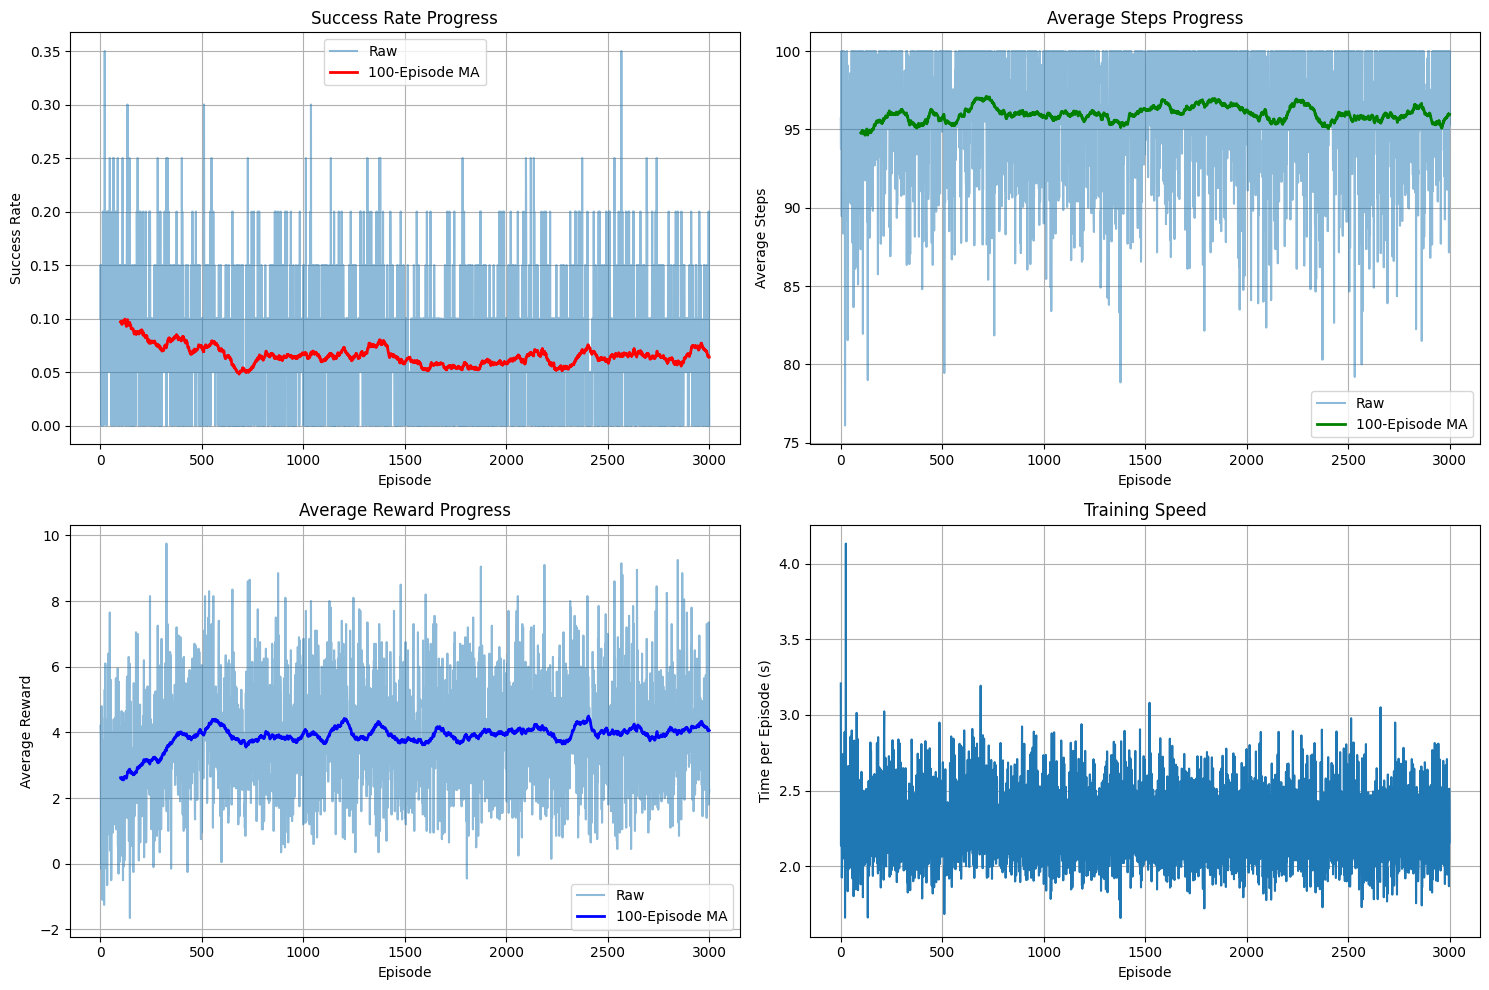


=== 训练统计 ===
总Episodes: 3000
最终成功率: 6.40%
最高成功率: 35.00%
最终平均步数: 96.0
最低平均步数: 76.1
平均训练时间: 2.21秒/episode


In [ ]:
# 绘制训练曲线
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 成功率
ax1 = axes[0, 0]
ax1.plot(stats['success_rate'], alpha=0.5, label='Raw')
if len(stats['success_rate']) >= 100:
    ma = pd.Series(stats['success_rate']).rolling(window=100).mean()
    ax1.plot(ma, 'r-', linewidth=2, label='100-Episode MA')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Success Rate')
ax1.set_title('Success Rate Progress')
ax1.legend()
ax1.grid(True)

# 平均步数
ax2 = axes[0, 1]
ax2.plot(stats['average_steps'], alpha=0.5, label='Raw')
if len(stats['average_steps']) >= 100:
    ma = pd.Series(stats['average_steps']).rolling(window=100).mean()
    ax2.plot(ma, 'g-', linewidth=2, label='100-Episode MA')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Steps')
ax2.set_title('Average Steps Progress')
ax2.legend()
ax2.grid(True)

# 奖励
ax3 = axes[1, 0]
ax3.plot(stats['episode_rewards'], alpha=0.5, label='Raw')
if len(stats['episode_rewards']) >= 100:
    ma = pd.Series(stats['episode_rewards']).rolling(window=100).mean()
    ax3.plot(ma, 'b-', linewidth=2, label='100-Episode MA')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average Reward')
ax3.set_title('Average Reward Progress')
ax3.legend()
ax3.grid(True)

# 训练速度
ax4 = axes[1, 1]
ax4.plot(stats['training_time'])
ax4.set_xlabel('Episode')
ax4.set_ylabel('Time per Episode (s)')
ax4.set_title('Training Speed')
ax4.grid(True)

plt.tight_layout()
plt.savefig(f'{save_dir}training_results.png', dpi=300)
plt.show()

# 打印最终统计
print("\n=== 训练统计 ===")
print(f"总Episodes: {len(stats['success_rate'])}")
print(f"最终成功率: {np.mean(stats['success_rate'][-100:]):.2%}")
print(f"最高成功率: {max(stats['success_rate']):.2%}")
print(f"最终平均步数: {np.mean(stats['average_steps'][-100:]):.1f}")
print(f"最低平均步数: {min(stats['average_steps']):.1f}")
print(f"平均训练时间: {np.mean(stats['training_time']):.2f}秒/episode")

## 8. 保存最终模型

In [ ]:
# 保存最终模型
final_checkpoint = {
    'total_episodes': len(stats['success_rate']),
    'final_success_rate': np.mean(stats['success_rate'][-100:]),
    'final_avg_steps': np.mean(stats['average_steps'][-100:]),
    'manager_params': system.manager.params,
    'picker_models': {}
}

for picker_id, picker in system.pickers.items():
    final_checkpoint['picker_models'][picker_id] = {
        'state_dict': picker.policy.state_dict(),
        'position': picker.position,
        'workload': picker.workload
    }

# 保存
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
final_path = f"{save_dir}hybrid_model_final_{timestamp}.pth"
torch.save(final_checkpoint, final_path)

# 保存完整统计
with open(f"{save_dir}final_stats_{timestamp}.json", 'w') as f:
    json.dump(stats, f)

print(f"\n✅ 模型已保存到: {final_path}")
print(f"✅ 统计已保存到: {save_dir}final_stats_{timestamp}.json")


✅ 模型已保存到: /content/drive/MyDrive/HybridModel/hybrid_model_final_20250810_133439.pth
✅ 统计已保存到: /content/drive/MyDrive/HybridModel/final_stats_20250810_133439.json


## 9. 下载模型到本地（可选）

In [ ]:
# 如果需要下载模型到本地
from google.colab import files

# 下载最终模型
files.download(final_path)

# 下载训练统计
files.download(f"{save_dir}final_stats_{timestamp}.json")

print("文件已开始下载...")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

文件已开始下载...
